# Deep Learning
### オンライン学習を導入する

#### データの前処理

In [1]:
import numpy as np
import pandas as pd
np.random.seed(443)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
## 学習用データ
DATA = pd.read_csv("train_data.csv")
TEST = pd.read_csv("test_data.csv")
DATA = pd.concat([DATA,TEST]).reset_index(drop=True)

# 使うデータを限定
use_valiable = ["DateTime","VIS","VIS_CAT","FG","PRCP_P24HR",\
                "RH_SFC","TMP_SFC","TD_SFC","PRES_SFC","LCDC_SFC","MCDC_SFC","HCDC_SFC",\
                "WSPD_SFC","WDIR_SFC","APCP_SFC","TimeRange","MONTH",\
#                 "D_PRES_SFC","D_TMP_SFC","D_TD_SFC",\
                "LL_VWS1","LL_VWS2","LL_STBL1","LL_STBL2","WARMER_RA",\
                "RH_1000","VVEL_1000","WSPD_1000","RH_975","VVEL_975","WSPD_975",\
                "RH_950","VVEL_950","WSPD_950","RH_850","RH_700","RH_500","RH_300"]
DATA = DATA[use_valiable]

# カテゴリー変数はダミー化
cat_val = ['WDIR_SFC', 'TimeRange', 'MONTH']
DATA = pd.get_dummies(data=DATA, columns=cat_val)

# 雨が降った後の夜間に霧が出やすいことを表現できるかもしれない
DATA["Time_12-14_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_12-14"]
DATA["Time_15-17_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_15-17"]
DATA["Time_18-20_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_18-20"]
DATA["Time_21-23_RAp24hr"] = DATA["PRCP_P24HR"] * DATA["TimeRange_21-23"]

### Chainerで学習

In [3]:
from chainer import Chain, Variable, configuration
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import Adam, MomentumSGD, RMSprop, SGD
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater
from chainer.training import Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator
from chainer.training.triggers import EarlyStoppingTrigger, MinValueTrigger
from chainer import serializers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import spearmanr
from pylab import rcParams
import re

/Users/calmtree443/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
target = 'VIS_CAT'
exclude = ["DateTime",'VIS','VIS_CAT','FG','PRCP_P24HR']
features = [val for val in DATA.columns if val not in exclude]

# 特徴量を割り算で作成
cutoff_r = 0.5
new_added_col = []
for i in range(0, len(features)-1):
    for j in range(i+1, len(features)):
        first_col_name = features[i]
        second_col_name = features[j]
        r = spearmanr(DATA[first_col_name], DATA[second_col_name]).correlation        
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            DATA[new_colname] = DATA[first_col_name] / (DATA[second_col_name] + 0.001)
            new_added_col.append(new_colname)
features = features + new_added_col

In [5]:
### SMOTEする
# VIS 5000m以上を減らし、VIS 5000m未満を増やす
def Over_Sampling( data ):
    data["FLAG"] = Sampling_Flag( data.VIS_CAT )

    target = 'FLAG'
    exclude = ['FLAG','DateTime']
    features = [val for val in DATA.columns if val not in exclude]

    y = np.array( data[target] )
    X = np.array( data[features] )

    count = int( y[y==0].shape[0] / 2 )
    sm = SMOTE(ratio={1:count}, random_state=443)
    X_sm, y_sm = sm.fit_sample(X,y)

    data_s = pd.DataFrame( X_sm, columns=features )
    data_s.FG = data_s.FG.astype(np.int64)
    data_s.VIS_CAT = data_s.VIS_CAT.astype(np.int64)
    return data_s

def Sampling_Flag(data):
    flag = np.full( data.shape[0], 0 )
    flag[ data > 0 ] = 1
    return flag

In [6]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(500)
            self.l2 = L.Linear(1000)
            self.l3 = L.Linear(500)
            self.l4 = L.Linear(5)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l3(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l4(h)
        return h

In [7]:
## 最もLOSSが低い（ACCURACYが高い）モデルを保存しておく
# by @koreyou
# https://qiita.com/koreyou/items/1982c2ac5bf0191fbe6b

import os
import random
import shutil
import tempfile

import chainer
from chainer.training import extension

def _snapshot_object(trainer, target, filename, savefun):
    fd, tmppath = tempfile.mkstemp()
    try:
        savefun(tmppath, target)
    except Exception:
        os.close(fd)
        os.remove(tmppath)
        raise
    os.close(fd)
    shutil.move(tmppath, filename)


class SaveRestore(chainer.training.extension.Extension):

    """Trainer extension to save a snapshot and restore it at the end of
    training.

    Typical usage is:

    .. code-block:: python

        trainer.extend(
            SaveRestore(),
            trigger=chainer.training.triggers.MinValueTrigger('validation/main/loss'))

    which save will save snapshots and apply (pseudo-) early stopping by
    loading the snapshot with the best validation loss.

    Args:
        filename (str): Name of the file into which the object is serialized.
            It can be a format string, where the trainer object is passed to
            the :meth:`str.format` method. For example,
            ``'snapshot_{.updater.iteration}'`` is converted to
            ``'snapshot_10000'`` at the 10,000th iteration.
            Or you can give name without formatter, which will overwrite the
            saved object on each call, thus only keeping the best model on
            the disk.
            Or you can give None, in which case the object is saved to
            a temporaly path and deleted at the end of the training.
        savefun: Function to save the object. It takes two arguments: the
            output file path and the object to serialize.
        loadfun: Function to load the object. It takes two arguments: the
            file path and the object to deserialize.
    """
    priority = -100

    def __init__(self, filename='snapshot_iter_{.updater.iteration}',
                 savefun=chainer.serializers.npz.save_npz,
                 loadfun=chainer.serializers.npz.load_npz):
        super(SaveRestore, self).__init__()
        self._savefun = savefun
        self._loadfun = loadfun
        self._saved_iteration = None
        self._keep_snapshot = filename is not None
        self._filename = filename or 'saverestore' + str(hash(random.random()))

    def __call__(self, trainer):
        fn = self._filename.format(trainer)
        self._saved_path = os.path.join(trainer.out, fn)
        if not os.path.exists(trainer.out):
            os.makedirs(trainer.out)        
        _snapshot_object(trainer, trainer, self._saved_path, self._savefun)
        self._saved_iteration = trainer.updater.iteration
        self._trainer = trainer  # get referencee to trainer

    def finalize(self):
        if self._saved_iteration is not None:
            print('Loading model from %d iteration' % self._saved_iteration)
            self._loadfun(self._saved_path, self._trainer)
        else:
            print('Warning: SaveRestore was never triggered')
        if not self._keep_snapshot and os.path.exists(self._saved_path):
            os.remove(self._saved_path)

In [8]:
## LOSS計算時に重み付けをする
def Loss_Func(x, t):
    cw = np.array([1, 2, 2, 3, 3]).astype(np.float32)
    return F.softmax_cross_entropy(x, t, class_weight=cw)

## カテゴリー評価
def Category_Evaluation(obs_cat, fcst_cat):
    matrix = confusion_matrix(y_true=obs_cat, y_pred=fcst_cat)
    print( matrix )
    print( "Accuracy : ", accuracy_score( obs_cat, fcst_cat ) )
    print( "F1 average : ", f1_score( obs_cat, fcst_cat, average='macro' ) )
    print( "Weighted F1 : ", Weighted_F1(matrix) )
    print( "ETS 800m : ", ETS(obs_cat, fcst_cat, 4) )
    print( "BI 800m : ", BI(obs_cat, fcst_cat, 4) )
    print( "ETS 1600m : ", ETS(obs_cat, fcst_cat, 3) )
    print( "BI 1600m : ", BI(obs_cat, fcst_cat, 3) )

def OneCat_Evaluation(obs_cat, fcst_cat):
    matrix = confusion_matrix(y_true=obs_cat, y_pred=fcst_cat)
    print( matrix )
    print( "Accuracy : ", accuracy_score( obs_cat, fcst_cat ) )
    print( "ETS 1600m : ", ETS(obs_cat, fcst_cat, 1) )
    print( "BI 1600m : ", BI(obs_cat, fcst_cat, 1) )

## Equitable Threat Score
def ETS(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    Pc = len(obs_onoff[ obs_onoff == 1 ]) / len(obs_onoff)
    Sf = Pc * ( m[1,1] + m[0,1] ) # ランダム的中率
    ets = ( m[1,1] - Sf ) / ( m[0,1] + m[1,0] + m[1,1] - Sf )
    return ets

## バイアススコア
def BI(obs_cat, fcst_cat, rank):
    obs_onoff = np.full( len(obs_cat), 0 )
    obs_onoff[ obs_cat >= rank ] = 1
    fcst_onoff = np.full( len(fcst_cat), 0 )
    fcst_onoff[ fcst_cat >= rank ] = 1

    m = confusion_matrix(y_true=obs_onoff, y_pred=fcst_onoff)
    bi = m[:,1].sum() / m[1,:].sum()
    return bi

## 各カテゴリーの総数の逆数で重み付け
# 低い視程カテゴリーの正解に重みをつけたい
def Weighted_F1(m):
    F1_score = []
    total = 0
    for i in range( len(m) ):
        if m[:,i].sum() == 0:
            precision = 0
        else:
            precision = m[i,i] / m[:,i].sum()

        if m[i,:].sum() == 0:
            recall = 0
        else:
            recall = m[i,i] / m[i,:].sum()

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        if m[i,:].sum() == 0:
            F1_score.append( 0 )
        else:
            F1_score.append( f1 / m[i,:].sum() )
            total += 1 / m[i,:].sum()

    fin_score = sum( F1_score ) / total
    return fin_score

#### 事前学習

In [9]:
pre_learn = 17429

# DATA_O = DATA[0:pre_learn].reset_index(drop=True)
# DATA_S = Over_Sampling( DATA_O )
# Y = DATA_S[target]
# X = DATA_S[features]
Y = DATA[target][0:pre_learn]
X = DATA[features][0:pre_learn]

scaler = StandardScaler()
X = scaler.fit_transform( X )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

## Chainer用の変換
Y_train = Y_train.values
Y_dev = Y_dev.values

X_train = X_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)

Y_train = Y_train.astype(np.int32)
Y_dev = Y_dev.astype(np.int32)

In [10]:
model = Model()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam()
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
# test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=1024, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=1024, shuffle=False, repeat=False)
# test_iterator = SerialIterator(test_dataset, batch_size=1024, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
stop_trigger = EarlyStoppingTrigger(check_trigger=(10, 'epoch'), monitor='dev/main/loss',\
                                    patients=10, max_trigger=(600, 'epoch'))

trainer = Trainer(updater, stop_trigger)
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
# trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss"]))
trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

logreport = LogReport(trigger=(1, 'epoch'))
trainer.extend(logreport)
trainer.run()

serializers.save_npz('DNN_CLF_CAT4.npz', model)

iteration   main/loss   dev/main/loss
12          1.14117     0.823959       
24          0.728925    0.720203       
36          0.667643    0.688414       
48          0.639586    0.662609       
60          0.61829     0.651228       
72          0.60801     0.63971        
84          0.590293    0.634516       
96          0.585025    0.621749       
108         0.579472    0.618706       
120         0.56449     0.618385       
132         0.55187     0.602066       
143         0.542608    0.600708       
155         0.540417    0.605403       
167         0.534434    0.591902       
179         0.525342    0.585495       
191         0.516156    0.581077       
203         0.516885    0.585973       
215         0.497711    0.573058       
227         0.502077    0.572185       
239         0.476261    0.565754       
251         0.481949    0.562809       
263         0.462793    0.563689       
275         0.460252    0.559314       
286         0.457145    0.55705        
29

,dev/main/accuracy,dev/main/loss,elapsed_time,epoch,iteration,main/accuracy,main/loss
30,0.877845,0.542155,58.093356,31,370,0.899984,0.403272
31,0.876967,0.544093,59.913507,32,382,0.901693,0.391254
32,0.876804,0.545886,61.187320,33,394,0.903727,0.391297
33,0.872084,0.540560,62.469840,34,406,0.902588,0.391252
34,0.880414,0.536982,64.265427,35,417,0.906161,0.384841


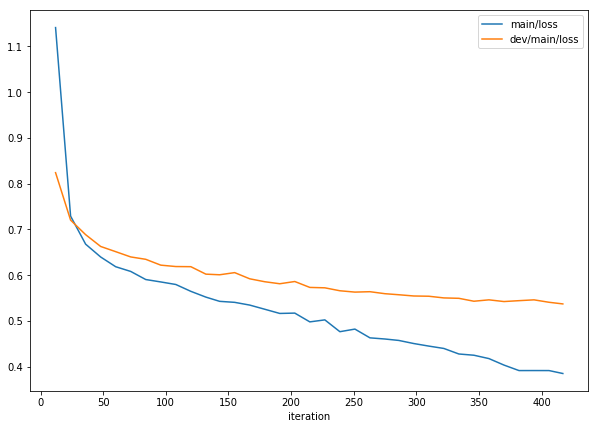

In [11]:
rcParams['figure.figsize'] = 10,7
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss"]].values, columns=["main/loss", "dev/main/loss"], index=log_df["iteration"]).plot()
log_df.tail()

In [12]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
# pd.crosstab(Y_dev, y_pred)
Category_Evaluation(Y_dev, y_pred)

             precision    recall  f1-score   support

          0       0.96      0.95      0.95      4583
          1       0.34      0.36      0.35       330
          2       0.39      0.38      0.38       232
          3       0.29      0.40      0.34        42
          4       0.42      0.67      0.51        42

avg / total       0.88      0.88      0.88      5229

[[4342  159   64    6   12]
 [ 123  120   66    9   12]
 [  52   63   88   20    9]
 [   8    4    7   17    6]
 [   5    2    1    6   28]]
Accuracy :  0.8787531076687704
F1 average :  0.5089895276961298
Weighted F1 :  0.4216295558368663
ETS 800m :  0.34130272023958075
BI 800m :  1.5952380952380953
ETS 1600m :  0.3666327514190854
BI 1600m :  1.4880952380952381


In [21]:
## LOSS計算時に重み付けをする
def Loss_Func(x, t):
    cw = np.array([1, 2, 2, 3, 3]).astype(np.float32)
    return F.softmax_cross_entropy(x, t, class_weight=cw)

In [22]:
### オンライン学習
## ループの設定
learn_hours = 30 * 24
one_step = 30 * 24
all_rows = DATA.shape[0]
repeat = int( (all_rows - pre_learn) / one_step )

fg_fcst = np.zeros( pre_learn )
fg_obs = np.zeros( pre_learn )

## 学習と予測ループ
for i in range( repeat + 1 ):
    print( "loop {} times of {}".format(i,repeat) )
    
    ## ループのパラメータ
    fcst_start = pre_learn + i * one_step
    fcst_end = fcst_start + one_step
    if i == repeat:
        fcst_end = all_rows
    learn_end = fcst_end
    learn_start = fcst_end - learn_hours
#     print( fcst_start, fcst_end, learn_start, learn_end )
    
    ## 予測
    Y_test = DATA[target][fcst_start:fcst_end]
    X_test = DATA[features][fcst_start:fcst_end]
    X_test = scaler.transform( X_test )

    Y_test = Y_test.values
    X_test = X_test.astype(np.float32)
    Y_test = Y_test.astype(np.int32)

    with configuration.using_config('train', False):
        y_calc = model(X_test)
    # y_arr = np.array([i.data for i in y_calc])
    # y_pred = np.argmax(y_arr, axis=1)
    y_pred = np.argmax(y_calc.data, axis=1)

    fg_fcst = np.r_[fg_fcst, y_pred]
    fg_obs = np.r_[fg_obs, Y_test]
    
    if i == repeat:
        break
    
    ## 学習
#     DATA_O = DATA[learn_start:learn_end].reset_index(drop=True)
#     DATA_S = Over_Sampling( DATA_O )
#     Y = DATA_S[target]
#     X = DATA_S[features]
    Y = DATA[target][learn_start:learn_end]
    X = DATA[features][learn_start:learn_end]

    scaler.partial_fit( X )
    X = scaler.transform( X )
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)
#     X_train = X
#     Y_train = Y

    ## Chainer用の変換
    Y_train = Y_train.values
    Y_dev = Y_dev.values

    X_train = X_train.astype(np.float32)
    X_dev = X_dev.astype(np.float32)

    Y_train = Y_train.astype(np.int32)
    Y_dev = Y_dev.astype(np.int32)

    ## Chainerを走らせる
    model = Model()
    if i == 0:
        serializers.load_npz("DNN_CLF_CAT4.npz", model)
    else:
        serializers.load_npz("DNN_CLF_CAT4_online.npz", model)
    classifier = L.Classifier( model, lossfun=Loss_Func )
#     optimizer = Adam()
    optimizer = SGD()
    optimizer.setup(classifier)

    train_dataset = TupleDataset(X_train, Y_train)
    dev_dataset = TupleDataset(X_dev, Y_dev)
    test_dataset = TupleDataset(X_test, Y_test)

    train_iterator = SerialIterator(train_dataset, batch_size=24, repeat=True)
    dev_iterator = SerialIterator(dev_dataset, batch_size=24, shuffle=False, repeat=False)
    test_iterator = SerialIterator(test_dataset, batch_size=24, shuffle=False, repeat=False)

    updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
    stop_trigger = EarlyStoppingTrigger(check_trigger=(1, 'epoch'), monitor='dev/main/loss',\
                                        patients=1, max_trigger=(2, 'epoch'))

    trainer = Trainer(updater, stop_trigger)
    trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
    trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
    trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))
    trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

    logreport = LogReport(trigger=(1, 'epoch'))
    trainer.extend(logreport)
    trainer.run()

    serializers.save_npz('DNN_CLF_CAT4_online.npz', model)

loop 0 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.214618    0.162488       0.163751        
Loading model from 42 iteration
loop 1 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.331555    0.304727       0.262609        
Loading model from 42 iteration
loop 2 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.457332    0.293714       0.317464        
Loading model from 42 iteration
loop 3 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.444097    0.380642       0.387104        
Loading model from 42 iteration
loop 4 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.455015    0.295634       0.319222        
Loading model from 42 iteration
loop 5 times of 23
iteration   main/loss   dev/main/loss  test/main/loss
21          0.767442    0.649037       0.635268        
Loading model from 21 iteration
loop 6 times of 23
iteration   mai

In [15]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[17429:26180], fg_fcst[17429:26180]))
# pd.crosstab(fg_obs[17429:26180], fg_fcst[17429:26180])
Category_Evaluation(fg_obs[17429:26180], fg_fcst[17429:26180])

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95      7850
        1.0       0.21      0.08      0.12       445
        2.0       0.31      0.38      0.34       343
        3.0       0.02      0.02      0.02        65
        4.0       0.12      0.29      0.17        48

avg / total       0.87      0.88      0.87      8751

[[7540   77  171   20   42]
 [ 263   37  101   17   27]
 [ 135   52  131    7   18]
 [  30    6   15    1   13]
 [  20    5    7    2   14]]
Accuracy :  0.8825277111187293
F1 average :  0.32059079304539767
Weighted F1 :  0.12669335001735518
ETS 800m :  0.09075302634149972
BI 800m :  2.375
ETS 1600m :  0.11541384690307413
BI 1600m :  1.424778761061947


In [16]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[26181:], fg_fcst[26181:]))
# pd.crosstab(fg_obs[26181:], fg_fcst[26181:])
Category_Evaluation(fg_obs[26181:], fg_fcst[26181:])

             precision    recall  f1-score   support

        0.0       0.93      0.96      0.95      7302
        1.0       0.29      0.14      0.19       376
        2.0       0.28      0.19      0.23       360
        3.0       0.03      0.02      0.02        55
        4.0       0.09      0.20      0.13        44

avg / total       0.86      0.88      0.87      8137

[[7044   82  107   14   55]
 [ 249   54   54    7   12]
 [ 222   52   68    6   12]
 [  37    1    9    1    7]
 [  28    0    4    3    9]]
Accuracy :  0.8818975052230552
F1 average :  0.3032926473251629
Weighted F1 :  0.09963756243895973
ETS 800m :  0.06553818702960243
BI 800m :  2.159090909090909
ETS 1600m :  0.09076165838472927
BI 1600m :  1.2727272727272727


### もっと深くしてみる

In [ ]:
class Model_D(Chain):
    def __init__(self):
        super(Model_D, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(500)
            self.l2 = L.Linear(1000)
            self.l3 = L.Linear(2000)
            self.l4 = L.Linear(1000)
            self.l5 = L.Linear(500)
            self.l6 = L.Linear(5)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l3(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l4(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l5(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l6(h)
        return h

In [ ]:
## LOSS計算時に重み付けをする
def Loss_Func(x, t):
    cw = np.array([1, 2, 2, 3, 3]).astype(np.float32)
    return F.softmax_cross_entropy(x, t, class_weight=cw)

In [ ]:
pre_learn = 17429

DATA_O = DATA[0:pre_learn].reset_index(drop=True)
DATA_S = Over_Sampling( DATA_O )
Y = DATA_S[target]
X = DATA_S[features]
# Y = DATA[target][0:pre_learn]
# X = DATA[features][0:pre_learn]

scaler = StandardScaler()
X = scaler.fit_transform( X )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

## Chainer用の変換
Y_train = Y_train.values
Y_dev = Y_dev.values

X_train = X_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)

Y_train = Y_train.astype(np.int32)
Y_dev = Y_dev.astype(np.int32)

In [ ]:
model = Model_D()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam()
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
# test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=1024, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=1024, shuffle=False, repeat=False)
# test_iterator = SerialIterator(test_dataset, batch_size=1024, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
stop_trigger = EarlyStoppingTrigger(check_trigger=(10, 'epoch'), monitor='dev/main/loss',\
                                    patients=10, max_trigger=(600, 'epoch'))

trainer = Trainer(updater, stop_trigger)
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
# trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss"]))
trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

logreport = LogReport(trigger=(1, 'epoch'))
trainer.extend(logreport)
trainer.run()

serializers.save_npz('DNN_CLF_CAT3.npz', model)

In [ ]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
# pd.crosstab(Y_dev, y_pred)
Category_Evaluation(Y_dev, y_pred)

In [ ]:
### オンライン学習
## ループの設定
learn_hours = 30 * 24
one_step = 30 * 24
all_rows = DATA.shape[0]
repeat = int( (all_rows - pre_learn) / one_step )

fg_fcst = np.zeros( pre_learn )
fg_obs = np.zeros( pre_learn )

## 学習と予測ループ
for i in range( repeat + 1 ):
    print( "loop {} times of {}".format(i,repeat) )
    
    ## ループのパラメータ
    fcst_start = pre_learn + i * one_step
    fcst_end = fcst_start + one_step
    if i == repeat:
        fcst_end = all_rows
    learn_end = fcst_end
    learn_start = fcst_end - learn_hours
#     print( fcst_start, fcst_end, learn_start, learn_end )
    
    ## 予測
    Y_test = DATA[target][fcst_start:fcst_end]
    X_test = DATA[features][fcst_start:fcst_end]
    X_test = scaler.transform( X_test )

    Y_test = Y_test.values
    X_test = X_test.astype(np.float32)
    Y_test = Y_test.astype(np.int32)

    with configuration.using_config('train', False):
        y_calc = model(X_test)
    # y_arr = np.array([i.data for i in y_calc])
    # y_pred = np.argmax(y_arr, axis=1)
    y_pred = np.argmax(y_calc.data, axis=1)

    fg_fcst = np.r_[fg_fcst, y_pred]
    fg_obs = np.r_[fg_obs, Y_test]
    
    if i == repeat:
        break
    
    ## 学習
#     DATA_O = DATA[learn_start:learn_end].reset_index(drop=True)
#     DATA_S = Over_Sampling( DATA_O )
#     Y = DATA_S[target]
#     X = DATA_S[features]
    Y = DATA[target][learn_start:learn_end]
    X = DATA[features][learn_start:learn_end]

    scaler.partial_fit( X )
    X = scaler.transform( X )
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)
#     X_train = X
#     Y_train = Y

    ## Chainer用の変換
    Y_train = Y_train.values
    Y_dev = Y_dev.values

    X_train = X_train.astype(np.float32)
    X_dev = X_dev.astype(np.float32)

    Y_train = Y_train.astype(np.int32)
    Y_dev = Y_dev.astype(np.int32)

    ## Chainerを走らせる
    model = Model_D()
    if i == 0:
        serializers.load_npz("DNN_CLF_CAT3.npz", model)
    else:
        serializers.load_npz("DNN_CLF_CAT3_online.npz", model)
    classifier = L.Classifier( model, lossfun=Loss_Func )
#     optimizer = Adam()
    optimizer = SGD()
    optimizer.setup(classifier)

    train_dataset = TupleDataset(X_train, Y_train)
    dev_dataset = TupleDataset(X_dev, Y_dev)
    test_dataset = TupleDataset(X_test, Y_test)

    train_iterator = SerialIterator(train_dataset, batch_size=24, repeat=True)
    dev_iterator = SerialIterator(dev_dataset, batch_size=24, shuffle=False, repeat=False)
    test_iterator = SerialIterator(test_dataset, batch_size=24, shuffle=False, repeat=False)

    updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
    stop_trigger = EarlyStoppingTrigger(check_trigger=(1, 'epoch'), monitor='dev/main/loss',\
                                        patients=1, max_trigger=(2, 'epoch'))

    trainer = Trainer(updater, stop_trigger)
    trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
    trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
    trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))
    trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

    logreport = LogReport(trigger=(1, 'epoch'))
    trainer.extend(logreport)
    trainer.run()

    serializers.save_npz('DNN_CLF_CAT3_online.npz', model)

In [ ]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[17429:26180], fg_fcst[17429:26180]))
# pd.crosstab(fg_obs[17429:26180], fg_fcst[17429:26180])
Category_Evaluation(fg_obs[17429:26180], fg_fcst[17429:26180])

In [ ]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[26181:], fg_fcst[26181:]))
# pd.crosstab(fg_obs[26181:], fg_fcst[26181:])
Category_Evaluation(fg_obs[26181:], fg_fcst[26181:])

### もっと浅くしてみる

In [ ]:
class Model_S(Chain):
    def __init__(self):
        super(Model_S, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(500)
            self.l2 = L.Linear(500)
            self.l3 = L.Linear(2)
    
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)

        h = self.l3(h)
        return h

In [ ]:
## LOSS計算時に重み付けをする
def Loss_Func(x, t):
    cw = np.array([1, 5]).astype(np.float32)
    return F.softmax_cross_entropy(x, t, class_weight=cw)

In [ ]:
pre_learn = 17429

DATA_O = DATA[0:pre_learn].reset_index(drop=True)
DATA_S = Over_Sampling( DATA_O )
Y = DATA_S[target]
X = DATA_S[features]
# Y = DATA[target][0:pre_learn]
# X = DATA[features][0:pre_learn]

scaler = StandardScaler()
X = scaler.fit_transform( X )
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)

## Chainer用の変換
Y_train = Y_train.values
Y_dev = Y_dev.values

X_train = X_train.astype(np.float32)
X_dev = X_dev.astype(np.float32)

Y_train = Y_train.astype(np.int32)
Y_dev = Y_dev.astype(np.int32)

In [ ]:
model = Model_S()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam()
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
# test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=1024, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=1024, shuffle=False, repeat=False)
# test_iterator = SerialIterator(test_dataset, batch_size=1024, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
stop_trigger = EarlyStoppingTrigger(check_trigger=(10, 'epoch'), monitor='dev/main/loss',\
                                    patients=10, max_trigger=(600, 'epoch'))

trainer = Trainer(updater, stop_trigger)
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
# trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss"]))
trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

logreport = LogReport(trigger=(1, 'epoch'))
trainer.extend(logreport)
trainer.run()

serializers.save_npz('DNN_CLF_FG3.npz', model)

In [ ]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
# pd.crosstab(Y_dev, y_pred)
OneCat_Evaluation(Y_dev, y_pred)

In [ ]:
### オンライン学習
## ループの設定
learn_hours = 30 * 24
one_step = 30 * 24
all_rows = DATA.shape[0]
repeat = int( (all_rows - pre_learn) / one_step )

fg_fcst = np.zeros( pre_learn )
fg_obs = np.zeros( pre_learn )

## 学習と予測ループ
for i in range( repeat + 1 ):
    print( "loop {} times of {}".format(i,repeat) )
    
    ## ループのパラメータ
    fcst_start = pre_learn + i * one_step
    fcst_end = fcst_start + one_step
    if i == repeat:
        fcst_end = all_rows
    learn_end = fcst_end
    learn_start = fcst_end - learn_hours
#     print( fcst_start, fcst_end, learn_start, learn_end )
    
    ## 予測
    Y_test = DATA[target][fcst_start:fcst_end]
    X_test = DATA[features][fcst_start:fcst_end]
    X_test = scaler.transform( X_test )

    Y_test = Y_test.values
    X_test = X_test.astype(np.float32)
    Y_test = Y_test.astype(np.int32)

    with configuration.using_config('train', False):
        y_calc = model(X_test)
    # y_arr = np.array([i.data for i in y_calc])
    # y_pred = np.argmax(y_arr, axis=1)
    y_pred = np.argmax(y_calc.data, axis=1)

    fg_fcst = np.r_[fg_fcst, y_pred]
    fg_obs = np.r_[fg_obs, Y_test]
    
    if i == repeat:
        break
    
    ## 学習
#     DATA_O = DATA[learn_start:learn_end].reset_index(drop=True)
#     DATA_S = Over_Sampling( DATA_O )
#     Y = DATA_S[target]
#     X = DATA_S[features]
    Y = DATA[target][learn_start:learn_end]
    X = DATA[features][learn_start:learn_end]

    scaler.partial_fit( X )
    X = scaler.transform( X )
    X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.3, random_state=443)
#     X_train = X
#     Y_train = Y

    ## Chainer用の変換
    Y_train = Y_train.values
    Y_dev = Y_dev.values

    X_train = X_train.astype(np.float32)
    X_dev = X_dev.astype(np.float32)

    Y_train = Y_train.astype(np.int32)
    Y_dev = Y_dev.astype(np.int32)

    ## Chainerを走らせる
    model = Model_S()
    if i == 0:
        serializers.load_npz("DNN_CLF_FG3.npz", model)
    else:
        serializers.load_npz("DNN_CLF_FG3_online.npz", model)
    classifier = L.Classifier( model, lossfun=Loss_Func )
#     optimizer = Adam()
    optimizer = SGD()
    optimizer.setup(classifier)

    train_dataset = TupleDataset(X_train, Y_train)
    dev_dataset = TupleDataset(X_dev, Y_dev)
    test_dataset = TupleDataset(X_test, Y_test)

    train_iterator = SerialIterator(train_dataset, batch_size=24, repeat=True)
    dev_iterator = SerialIterator(dev_dataset, batch_size=24, shuffle=False, repeat=False)
    test_iterator = SerialIterator(test_dataset, batch_size=24, shuffle=False, repeat=False)

    updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
    stop_trigger = EarlyStoppingTrigger(check_trigger=(1, 'epoch'), monitor='test/main/loss',\
                                        patients=3, max_trigger=(2, 'epoch'))

    trainer = Trainer(updater, stop_trigger)
    trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
    trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
    trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))
    trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

    logreport = LogReport(trigger=(1, 'epoch'))
    trainer.extend(logreport)
    trainer.run()

    serializers.save_npz('DNN_CLF_FG3_online.npz', model)

In [ ]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[17429:26180], fg_fcst[17429:26180]))
# pd.crosstab(fg_obs[17429:26180], fg_fcst[17429:26180])
OneCat_Evaluation(fg_obs[17429:26180], fg_fcst[17429:26180])

In [ ]:
# 2016年：17429 - 26180
# 2017年：26181 - 
print(classification_report(fg_obs[26181:], fg_fcst[26181:]))
# pd.crosstab(fg_obs[26181:], fg_fcst[26181:])
OneCat_Evaluation(fg_obs[26181:], fg_fcst[26181:])

In [ ]:
model = Model()
classifier = L.Classifier( model, lossfun=Loss_Func )
optimizer = Adam()
optimizer.setup(classifier)

train_dataset = TupleDataset(X_train, Y_train)
dev_dataset = TupleDataset(X_dev, Y_dev)
test_dataset = TupleDataset(X_test, Y_test)

train_iterator = SerialIterator(train_dataset, batch_size=64, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=64, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=64, shuffle=False, repeat=False)

updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
stop_trigger = EarlyStoppingTrigger(check_trigger=(1, 'epoch'), monitor='dev/main/loss',\
                                    patients=10, max_trigger=(300, 'epoch'))

trainer = Trainer(updater, stop_trigger)
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(1, 'epoch'), name="dev")
trainer.extend(Evaluator(test_iterator, classifier), trigger=(1, 'epoch'), name="test")
trainer.extend(PrintReport(['iteration', "main/loss", "dev/main/loss", "test/main/loss"]))
trainer.extend(SaveRestore(), trigger=MinValueTrigger('dev/main/loss', trigger=(1, 'epoch')))

logreport = LogReport(trigger=(1, 'epoch'))
trainer.extend(logreport)
trainer.run()

serializers.save_npz('DNN_CLF_FG2', model)

In [ ]:
rcParams['figure.figsize'] = 10,7
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "dev/main/loss", "test/main/loss"]].values, columns=["main/loss", "dev/main/loss", "test/main/loss"], index=log_df["iteration"]).plot()
log_df.tail()

In [ ]:
with configuration.using_config('train', False):
    y_calc = model(X_dev)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_dev, y_pred))
pd.crosstab(Y_dev, y_pred)

In [ ]:
OneCat_Evaluation(Y_dev, y_pred)

In [ ]:
with configuration.using_config('train', False):
    y_calc = model(X_test)
# y_arr = np.array([i.data for i in y_calc])
# y_pred = np.argmax(y_arr, axis=1)
y_pred = np.argmax(y_calc.data, axis=1)
print(classification_report(Y_test, y_pred))
pd.crosstab(Y_test, y_pred)

In [ ]:
OneCat_Evaluation(Y_test, y_pred)